In [ ]:
# Filters
# Num calls 
# Total length > 40 in ref
# Samples with Num calls outliers
# Families with Mend inheritance outliers
# NFILT too high
# Stutter too high

In [2]:
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib.patches import Polygon

VCFPATH="/storage/s1saini/hipstr_rerun/"
HIPREF="/storage/resources/dbase/human/hs37d5/GRCh37.hipstr_reference.bed"
TMPPATH="/storage/mgymrek/ssc-imputation/tmp"

colors = ["gray","red","gold","blue","green","purple"]

hipstr = pd.read_csv(HIPREF, sep="\t", names=["chrom","start","end","period","score","name"])
hipstr = hipstr[hipstr["chrom"].apply(lambda x: x not in ["X","Y"])]
hipstr["chrom"] = hipstr["chrom"].apply(str)

MINLOB = 300 # Min number of 1000G calls to include in heterozygosity comparison

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Preprocess VCFs

In [3]:
header = ["chrom","start","end","AN","period","pgeom","up","down","bpdiffs","AC","NFILT","NSKIP"]
locstats = pd.read_csv(os.path.join(TMPPATH, "locus_stats.tab"), names=header, sep="\t")
locstats = pd.merge(hipstr, locstats, on=["chrom","start","end","period"], how="left")
locstats.ix[np.isnan(locstats["AN"]), "AN"] = 0
locstats["numcalls"] = locstats["AN"].apply(lambda x: int(x)/2)

In [3]:
sampstats = pd.read_fwf(os.path.join(TMPPATH, "sample_stats.tab"), names=["numloci","sample"])
sampstats = sampstats.groupby("sample", as_index=False).agg({"numloci": np.sum})

# Scratch - checking for batch artifacts
Move after we resolve these issues

In [4]:
BATCHSIZE=500
# Calculate batch number
locstats["num"] = -1
for chrom in range(1, 23):
    numchrom = locstats[locstats["chrom"].apply(str)==str(chrom)].shape[0]
    locstats.ix[locstats["chrom"].apply(str)==str(chrom),"num"] = range(numchrom)
locstats["batchnum"] = locstats.apply(lambda x: str(x["chrom"])+"_"+str(int(x["num"]/BATCHSIZE)), 1)
batches = locstats.groupby("batchnum", as_index=False).agg({"numcalls": np.mean,"chrom":len})
#batches.sort("numcalls").to_csv("batch_stats.csv", index=False)

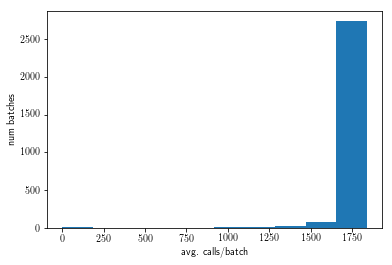

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(batches[batches["chrom"]==BATCHSIZE]["numcalls"]);
ax.set_xlabel("avg. calls/batch")
ax.set_ylabel("num batches");

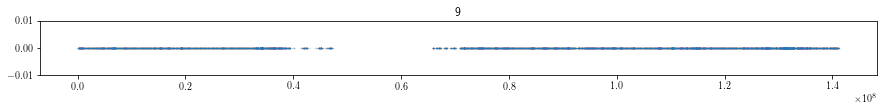

In [10]:
chrom = 9
fig = plt.figure()
fig.set_size_inches((15, 1))
ax = fig.add_subplot(111)
x = locstats[locstats["chrom"].apply(str)==str(chrom)]
ax.scatter(x["start"], x["numcalls"], alpha=0.01, s=1);
ax.set_title(chrom);

# Call rate per locus

In [18]:
# Overall call rate
1-locstats[locstats["numcalls"]==0].shape[0]/locstats.shape[0]

0.9139235516300219

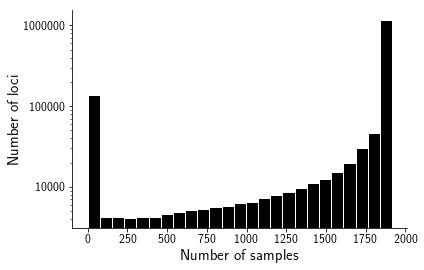

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(locstats["numcalls"], log=True, color="black", edgecolor="white", bins=25);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Number of samples", size=15)
ax.set_ylabel("Number of loci", size=15)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);

# Length bias

In [39]:
def GetMeanDiff(x):
    total_alleles = x["AN"]
    total_diff = 0
    if total_alleles == 0: return 0
    if x["AC"]==".": return 0
    alts = x["bpdiffs"].split(",")
    counts = x["AC"].split(",")
    for i in range(len(alts)):
        total_diff += int(alts[i])*int(counts[i])
    return total_diff*1.0/total_alleles

locstats["length"] = locstats["end"]-locstats["start"]+1
locstats["meandiff"] = locstats.apply(GetMeanDiff, 1)

reflen = range(10, 100)
diffs = []
percs = []
for rl in reflen:
    x = locstats[locstats["length"]==rl]
    if x.shape[0] <= 25:
        diffs.append(np.nan)
    else: diffs.append(sum(x.apply(lambda x: x["meandiff"]*x["numcalls"], 1))/sum(x["numcalls"]))
    percs.append(locstats[locstats["length"]<=rl].shape[0]*1.0/locstats.shape[0])

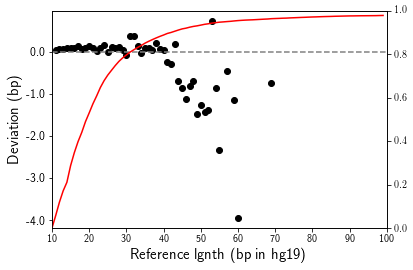

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(reflen, diffs, color="black");
ax.set_xlabel("Reference length (bp in hg19)", size=15)
ax.set_ylabel("Deviation (bp)", size=15)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y=0, linestyle="dashed", color="gray")
ax.set_xlim(left=10, right=100)

ax2 = ax.twinx()
ax2.plot(reflen, percs, color="red");
ax2.set_ylim(bottom=0, top=1)
ax2.set_xlim(left=10, right=100)
ax2.set_xticklabels([int(x) for x in ax.get_xticks()], size=12);

# Stutter

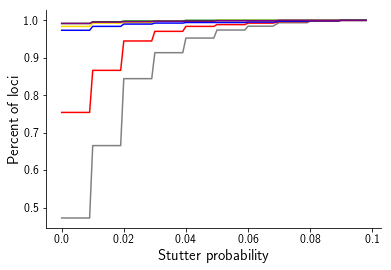

In [90]:
fig = plt.figure()
ax = fig.add_subplot(111)
bins = np.arange(0, 0.1, 0.001)
for period in range(1, 7):
    x = locstats[(locstats["period"]==period) & (locstats["AN"]>=0) & ~np.isnan(locstats["pgeom"])]
    counts, bins = np.histogram(x["stutterprob"], bins=bins)
    total = sum(counts)
    counts = np.cumsum(counts)
    counts = [item*1.0/total for item in counts]
    ax.plot(bins[:-1], counts, color=colors[period-1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Stutter probability", size=15)
ax.set_ylabel("Percent of loci", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12);

# Calls/sample

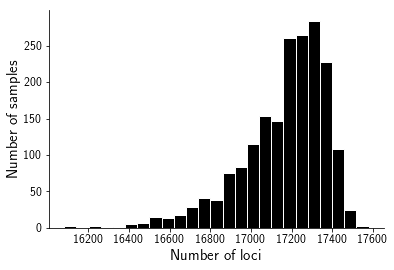

In [98]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(sampstats["numloci"], color="black", edgecolor="white", bins=25);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Number of loci", size=15)
ax.set_ylabel("Number of samples", size=15)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);

# Mendelian inheritance

In [2]:
mend = pd.read_csv(os.path.join(TMPPATH, "mend_stats.tab"),
                   names=["chrom","start","sample","Q","DP","mend"], sep="\t")
mend["mend"] = mend["mend"].apply(int)
mend = pd.merge(mend, hipstr, on=["chrom","start"])
# TODO remove if homref

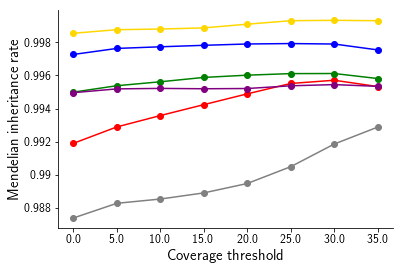

In [3]:
# Mendelian inheritance vs. coverage
fig = plt.figure()
ax = fig.add_subplot(111)
coverages = np.arange(0, 40, 5)

for period in range(1, 7):
    mend_scores = []
    for cov in coverages:
        x = mend[(mend["DP"]>=cov) & (mend["period"]==period)]
        if x.shape[0] >= 50:
            mend_scores.append(np.mean(x["mend"]))
        else: mend_scores.append(np.nan)
    ax.plot(coverages, mend_scores, color=colors[period-1], marker="o");
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Coverage threshold", size=15)
ax.set_ylabel("Mendelian inheritance rate", size=15)
ax.set_xticklabels([(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);

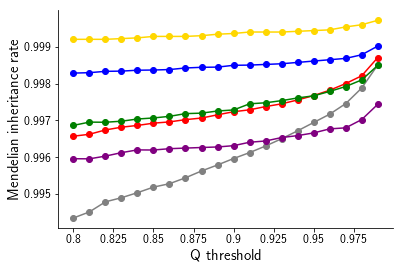

In [28]:
# Mendelian inheritance vs. qual
fig = plt.figure()
ax = fig.add_subplot(111)
scores = np.arange(0.8, 1, 0.01)

for period in range(1, 7):
    mend_scores = []
    for q in scores:
        x = mend[(mend["Q"]>=q) & (mend["period"]==period)]
        if x.shape[0] >= 50:
            mend_scores.append(np.mean(x["mend"]))
        else: mend_scores.append(np.nan)
    ax.plot(scores, mend_scores, color=colors[period-1], marker="o");
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Q threshold", size=15)
ax.set_ylabel("Mendelian inheritance rate", size=15)
ax.set_xticklabels([(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);

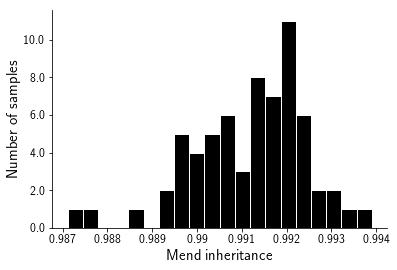

In [10]:
# Mendelian inheritance per sample
mend_bysamp = mend.groupby(["sample"], as_index=False).agg({"mend":np.mean})
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(mend_bysamp["mend"], color="black", edgecolor="white", bins=20);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Mend inheritance", size=15)
ax.set_ylabel("Number of samples", size=15)
ax.set_xticklabels([(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);

# Comparison to lobSTR heterozygosities

In [ ]:
# TODO filter NFILT, NSKIP, num calls

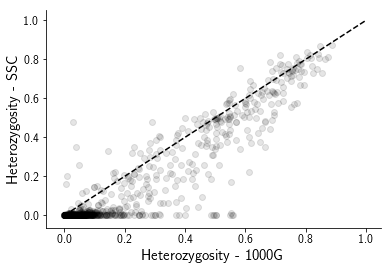

In [50]:
lobstr = pd.read_csv(os.path.join(TMPPATH, "lobstr_het_stats.tab"), sep="\t", names=["chrom","start","het_lobstr","numcalls"])
lobstr["chrom"] = lobstr["chrom"].apply(lambda x: int(x[3:]))
lobstr = lobstr[lobstr["numcalls"]>=MINLOB]

hiphet = pd.read_csv(os.path.join(TMPPATH, "het_stats.tab"), sep="\t",
                                  names=["chrom","start","end","num_alleles","num_alleles_length","het_ssc_length","het_ssc"])
hiphet["length"] = hiphet["end"]-hiphet["start"]+1
het = pd.merge(lobstr, hiphet, on=["chrom","start"])
het = pd.merge(het, hipstr, on=["chrom","start"])
fig = plt.figure()
ax = fig.add_subplot(111)
x = het 
ax.scatter(x["het_lobstr"], x["het_ssc_length"], color="black", alpha=0.1);
ax.plot([0,1],[0,1], linestyle="dashed", color="black")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Heterozygosity - 1000G", size=15)
ax.set_ylabel("Heterozygosity - SSC", size=15)
ax.set_xticklabels([(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);